## Import libraries


In [1]:
 import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install imbalanced-learn
!python -m textblob.download_corpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_dat

In [2]:
import numpy as np
import pandas as pd
from time import time
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, fbeta_score, accuracy_score, confusion_matrix, plot_roc_curve, ConfusionMatrixDisplay, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Mounting Google Drive
from google.colab import drive  # to mount Google Drive to Colab notebook
drive.mount('/content/gdrive')
#path = './gdrive/My Drive/SharedFolder/Data_and_Code/'
#path = './gdrive/My Drive/KSUSentAnalysisWorkshop/SharedFolder/Data_and_Code/'
path = './gdrive/My Drive/SWE486Team2/Data_and_Code/'


Mounted at /content/gdrive


In [4]:
!pwd

/content


In [5]:
# read csv file and save it in a data frame
data_df=pd.read_csv('/content/gdrive/MyDrive/SWE486Team2 /Data_and_Code/final_reviews_cleaned.csv') 
#data_df=pd.read_excel(path+'Data.xlsx') 

In [6]:
data_df.head()

,Unnamed: 0,reviews,sentiment
0,5122,ِ الفندق جميل الخدمة جيدة الغرف وباقي منشآت ال...,Positive
1,5344,آجمل فندق فندق جميل ونظيف جدا وقريب الحرم ويقع...,Positive
2,68,آزيموت سكاي بارإطلالة بانورامية مدينة الليل يق...,Negative
3,69,آسف يؤسفني أني حجزت الإنترنت وعندما وصلت إليه ...,Negative
4,70,آسفون مرة أخرى إنني آمل أنه متواضعاً جداً لكنن...,Negative


In [7]:
data_df.drop(data_df.columns[data_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [8]:
data_df.head()

,reviews,sentiment
0,ِ الفندق جميل الخدمة جيدة الغرف وباقي منشآت ال...,Positive
1,آجمل فندق فندق جميل ونظيف جدا وقريب الحرم ويقع...,Positive
2,آزيموت سكاي بارإطلالة بانورامية مدينة الليل يق...,Negative
3,آسف يؤسفني أني حجزت الإنترنت وعندما وصلت إليه ...,Negative
4,آسفون مرة أخرى إنني آمل أنه متواضعاً جداً لكنن...,Negative


# Model Training

### Feature Extraction

In [9]:

#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn import svm
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
#from sklearn.metrics  import confusion_matrix, classification_report
#from sklearn import metrics

In [10]:
# remove data with NAN sentiment
data_df=data_df[~data_df["sentiment"].isna()]
data_df=data_df[~data_df["reviews"].isna()]

In [11]:
# remove the "Neutral" class
data_df=data_df[data_df['sentiment'] != "Neutral"]

In [12]:
data_df.head(5)

,reviews,sentiment
0,ِ الفندق جميل الخدمة جيدة الغرف وباقي منشآت ال...,Positive
1,آجمل فندق فندق جميل ونظيف جدا وقريب الحرم ويقع...,Positive
2,آزيموت سكاي بارإطلالة بانورامية مدينة الليل يق...,Negative
3,آسف يؤسفني أني حجزت الإنترنت وعندما وصلت إليه ...,Negative
4,آسفون مرة أخرى إنني آمل أنه متواضعاً جداً لكنن...,Negative


In [13]:
# change values to numeric
data_df['sentiment'] = data_df['sentiment'].map({'Positive':1, 'Negative':0}) 

In [14]:
data_df.head()

,reviews,sentiment
0,ِ الفندق جميل الخدمة جيدة الغرف وباقي منشآت ال...,1
1,آجمل فندق فندق جميل ونظيف جدا وقريب الحرم ويقع...,1
2,آزيموت سكاي بارإطلالة بانورامية مدينة الليل يق...,0
3,آسف يؤسفني أني حجزت الإنترنت وعندما وصلت إليه ...,0
4,آسفون مرة أخرى إنني آمل أنه متواضعاً جداً لكنن...,0


## data splitting

>Unsampled data

In [15]:
# idneitfy the data and the labels
X= data_df['reviews']
y= data_df['sentiment']

In [16]:
# Use TfidfVectorizer for feature extraction (TFIDF to convert textual data to numeric form):
# Convert to a vector representation
unsampled_tfidf = TfidfVectorizer() 
unsampled_X = unsampled_tfidf.fit_transform(X)
unsampled_X.shape

(13729, 90506)

In [17]:
unsampled_X

<13729x90506 sparse matrix of type '<class 'numpy.float64'>'
	with 824147 stored elements in Compressed Sparse Row format>

In [18]:
# Training Phase
X_train_unsampled, X_test_unsampled, y_train_unsampled, y_test_unsampled = train_test_split(unsampled_X, y, test_size=0.3, random_state=27)
# i suggest changing the test_size to 0.2

In [19]:
print("Training set has {} samples.".format(X_train_unsampled.shape[0]))
print("Testing set has {} samples.".format(X_test_unsampled.shape[0]))

Training set has 9610 samples.
Testing set has 4119 samples.


>Upsampled Data

In [20]:
upsampled_tfidf = TfidfVectorizer()
upsampled_tfidf.fit(X)

TfidfVectorizer()

In [21]:
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X,y, test_size=0.3, random_state=27)


In [22]:
print("Training set has {} samples.".format(X_train_upsampled.shape[0]))
print("Testing set has {} samples.".format(X_test_upsampled.shape[0]))

Training set has 9610 samples.
Testing set has 4119 samples.


In [23]:
X_train_upsampled = upsampled_tfidf.transform(X_train_upsampled)
X_test_upsampled = upsampled_tfidf.transform(X_test_upsampled)
upsampled_X = upsampled_tfidf.transform(X)


In [24]:
X_train_upsampled

<9610x90506 sparse matrix of type '<class 'numpy.float64'>'
	with 576284 stored elements in Compressed Sparse Row format>

In [25]:
ros = RandomOverSampler(random_state=27)

X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train_upsampled, y_train_upsampled)

In [26]:
print("Data before upsampling: {} samples.".format(y_train_unsampled.value_counts()[0]))
print("Data before upsampling: {} samples.".format(y_train_unsampled.value_counts()[1]))

Data before upsampling: 2291 samples.
Data before upsampling: 7319 samples.


In [27]:
print("Data after upsampling: {} samples.".format(y_train_upsampled.value_counts()[0]))
print("Data after upsampling: {} samples.".format(y_train_upsampled.value_counts()[1]))

Data after upsampling: 7319 samples.
Data after upsampling: 7319 samples.


## Training Pipeline

In [28]:
def train_predict_pipeline(model, X_train, y_train, X_test, y_test, X, y):
    print("            {} Training            ".format(model.__class__.__name__))
    results = {}

    start = time()  # Training start
    model = model.fit(X_train, y_train) # Train the model
    end = time()  # Training end
    results['training_time'] = end - start # Store the time

    start = time()  # Prediction start
    predictions_test = model.predict(X_test) # Predict
    predictions_train = model.predict(X_train)
    end = time()  # Prediction end
    results['prediction_time'] = end - start # Store the time


    results['model_accuracy'] = model.score(X_train, y_train) # Overall accuracy

    # Cross validation score
    cross_validation_scores = cross_val_score(model,X, y, cv=10)
    results['model_cross_validation'] = np.mean(cross_validation_scores) 

    # Accuracy scores - for plotting
    results['accuracy_train'] = accuracy_score(y_train, predictions_train)
    results['accuracy_test'] = accuracy_score(y_test, predictions_test)

    # F-scores
    results['fbeta_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
    results['fbeta_test'] = fbeta_score(y_test, predictions_test, beta=0.5)

    # Print the report
    print('            Accuracy Report            ')
    print('Model Accuracy: %.2f' % results['model_accuracy'])
    print('10-Fold Cross Validation: %.2f' % results['model_cross_validation'])
    print('F-beta Score (Training): %.2f' % results['fbeta_train'])
    print('F-beta Score (Testing): %.2f' % results['fbeta_test'])
    print('            Confusion Matrix            ')
    print(confusion_matrix(y_test, predictions_test))
    print(classification_report(y_test, predictions_test))

    display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['negative', 'positive'], cmap=plt.cm.Blues)
    display.ax_.set_title('Confusion Matrix Display')
    plt.show()

    # Return the results and the classifier
    return results, model

In [29]:

Naivebayes_classifier = MultinomialNB()
logisticregression_classifier= LogisticRegression(C=1.0, max_iter=3000)

            MultinomialNB Training            
            Accuracy Report            
Model Accuracy: 0.79
10-Fold Cross Validation: 0.78
F-beta Score (Training): 0.82
F-beta Score (Testing): 0.82
            Confusion Matrix            
[[  25  888]
 [   1 3205]]
              precision    recall  f1-score   support

           0       0.96      0.03      0.05       913
           1       0.78      1.00      0.88      3206

    accuracy                           0.78      4119
   macro avg       0.87      0.51      0.47      4119
weighted avg       0.82      0.78      0.70      4119



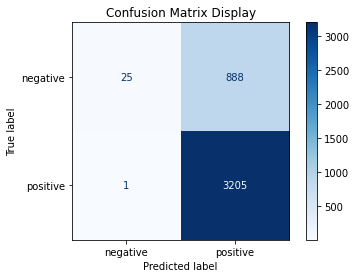

            LogisticRegression Training            
            Accuracy Report            
Model Accuracy: 0.96
10-Fold Cross Validation: 0.92
F-beta Score (Training): 0.96
F-beta Score (Testing): 0.93
            Confusion Matrix            
[[ 598  315]
 [  28 3178]]
              precision    recall  f1-score   support

           0       0.96      0.65      0.78       913
           1       0.91      0.99      0.95      3206

    accuracy                           0.92      4119
   macro avg       0.93      0.82      0.86      4119
weighted avg       0.92      0.92      0.91      4119



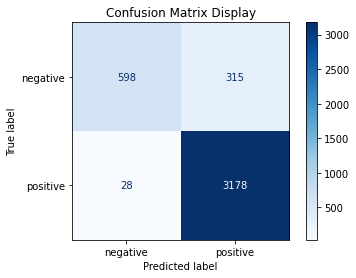

In [30]:
results_raw = {}

for classifier in [ Naivebayes_classifier, logisticregression_classifier]:
    classifier_name = classifier.__class__.__name__
    results_raw[classifier_name] = {}
    results_raw[classifier_name], classifier = train_predict_pipeline(
classifier, X_train_unsampled, y_train_unsampled, X_test_unsampled, y_test_unsampled, unsampled_X, y)

In [31]:
Naivebayes_classifier = MultinomialNB()
logisticregression_classifier= LogisticRegression(C=1.0, max_iter=3000)

            MultinomialNB Training            
            Accuracy Report            
Model Accuracy: 0.98
10-Fold Cross Validation: 0.78
F-beta Score (Training): 0.99
F-beta Score (Testing): 0.97
            Confusion Matrix            
[[ 842   71]
 [ 222 2984]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       913
           1       0.98      0.93      0.95      3206

    accuracy                           0.93      4119
   macro avg       0.88      0.93      0.90      4119
weighted avg       0.94      0.93      0.93      4119



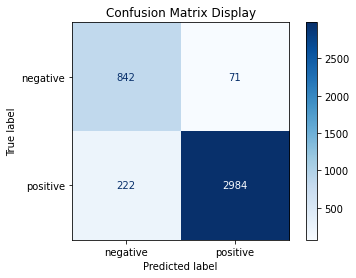

            LogisticRegression Training            


In [ ]:
results = {}

for classifier in [ Naivebayes_classifier, logisticregression_classifier]:
    classifier_name = classifier.__class__.__name__
    results[classifier_name] = {}
    results[classifier_name], classifier = train_predict_pipeline(
        classifier, X_train_upsampled, y_train_upsampled, X_test_upsampled, y_test_upsampled, upsampled_X, y)


# Model Evaluation

In [ ]:
def evaluate(results, accuracy, f1):
  # Visualization code to display results
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
 # Constants
    bar_width = 0.3
    colors = ['#083471', '#1F6EB3', '#56A0CE']
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['training_time', 'accuracy_train', 'fbeta_train', 'prediction_time', 'accuracy_test', 'fbeta_test']):
            ax[j//3, j % 3].bar(k*bar_width, results[learner]
                                [metric], width=bar_width, color=colors[k])
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("Fbeta-score")
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("Fbeta-score on Testing Set")
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y=accuracy, xmin=-0.1, xmax=3.0,
                     linewidth=1, color='k', linestyle='dashed')
    ax[1, 1].axhline(y=accuracy, xmin=-0.1, xmax=3.0,
                     linewidth=1, color='k', linestyle='dashed')
    ax[0, 2].axhline(y=f1, xmin=-0.1, xmax=3.0, linewidth=1,
                     color='k', linestyle='dashed')
    ax[1, 2].axhline(y=f1, xmin=-0.1, xmax=3.0, linewidth=1,
                     color='k', linestyle='dashed')
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color=colors[i], label=learner))
    plt.legend(handles=patches, bbox_to_anchor=(-.80, 2.53),
               loc='upper center', borderaxespad=0., ncol=3, fontsize='x-large')
    # Aesthetics
    plt.suptitle(
        "Performance Metrics for Two Supervised Learning Models", fontsize=16, y=1.10)
    plt.show()


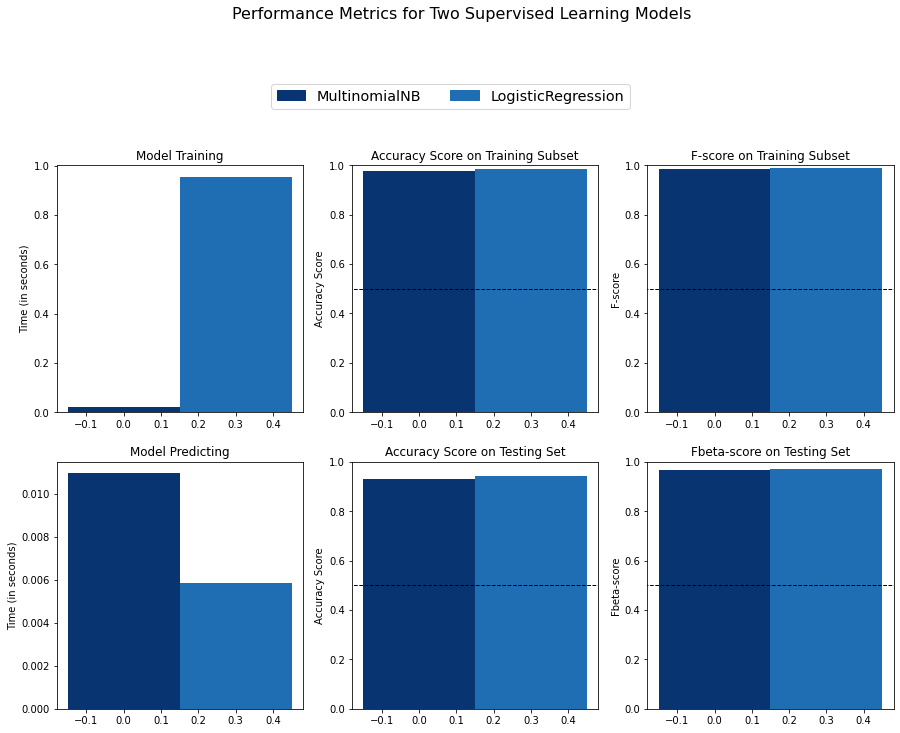

In [ ]:
evaluate(results, 0.5, 0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


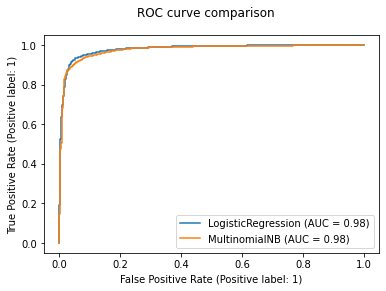

In [ ]:
logisticregression_display = plot_roc_curve(logisticregression_classifier, X_test_upsampled, y_test_upsampled)
naive_display = plot_roc_curve(Naivebayes_classifier, X_test_upsampled, y_test_upsampled, ax=logisticregression_display.ax_)
naive_display.figure_.suptitle("ROC curve comparison")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.show()